### Описание проекта

Дано: данные клиентов компании по продаже автомобилей с пробегом «Не бит, не крашен». 

Задача:  построить модель для определения стоимости автомобиля. 

Бизнес-цель: привлечение новых клиентов с помощью приложения.

<a id='Назад к оглавлению'></a>

### План Исследования

#### Поделим наще исследование на несколько частей.

#### Часть 1. Анализ общей информации
<a href='#Анализ общей информации'> 1.1 Загрузка библиотек, чтение данных и анализ общей информации</a>

#### Часть 2. Предобработка данных
<a href='#Часть 2. Предобработка данных'> 2.1 Предобработка данных и разбиение на выборки</a>

#### Часть 3. Разбиение данных на выборки и построение моделей
<a href='#Часть 3. Разбиение данных на выборки'> 3.1 Разбиение данных на выборки</a>

<a href='#3.2 Константная модель'> 3.2 Константная модель</a>

<a href='#3.3 Random Forest Regressor'> 3.3 Random Forest Regressor</a>

<a href='#3.4 LGBM'> 3.4 LGBM</a>

<a href='#3.5 CatBoost'> 3.5 CatBoost</a>  

#### Часть 4. Общий вывод
<a href='#4. Общий вывод'> 4.1 Общий вывод</a>

<a id='Анализ общей информации'></a>

### Часть 1. Анализ данных

#### 1.1 Загрузка библиотек, чтение данных и анализ общей информации

In [1]:
# Для анализа данных будем использовать библиотеку pandas_profiling.
# Установим библиотеку и изменим версию pandas c которой profiling работает стабильно
!pip install pandas_profiling==1.4.1
!pip install pandas==0.25.3
!pip install lightgbm
!pip install missingno

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 10.4 MB 394 kB/s eta 0:00:01
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [4]:
# Импортируем библиотеки, с помощью которых будем обрабатывать данные
import pandas_profiling # для анализа статистик и распределений данных
import pandas as pd # для работы с табличными данными
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns
import missingno as msno # для визуализации пропусков в данных
%matplotlib inline

import timeit

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import MissingIndicator #для создания колонки с индикатором пропусков
from sklearn.metrics import mean_squared_error, make_scorer

from catboost import CatBoostRegressor, Pool, cv
import lightgbm as lgbm

# Игнорирование предупреждения об ошибках
import warnings
warnings.filterwarnings('ignore')

# Установка настроек для отображения всех колонок и строк при печати
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [5]:
# Прочитаем данные из файла и запишем в переменную df
df = pd.read_csv('/datasets/autos.csv')

In [4]:
# Используем метод info для определения типов данных признаков
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [5]:
# Запусим библиотеку pandas_profiling и посмотрим как выглядят статистики 
pandas_profiling.ProfileReport(df)

Number of variables,16
Number of observations,354369
Total Missing (%),3.2%
Total size in memory,43.3 MiB
Average record size in memory,128.0 B
Numeric,6
Categorical,9
Boolean,0
Date,0
Text (Unique),0
Rejected,1


Инструмент pandas_profiling позволяет изучить основную информацию о значениях и статистиках по признакам. Автоматический анализатор позволяет быстро получить информацию о типах данных, распределениях, наличиях пропусков и дублей в наборе данных. Так же можно увидеть информацию о корреляции между признаками или признаками и целевой переменной. Данный инструмент не позволяет ответить на все вопросы о наших данных, но помогает довольно быстро оценить основные проблемы, присутствующие в данных и определиться с инструментами для более детального анализа.

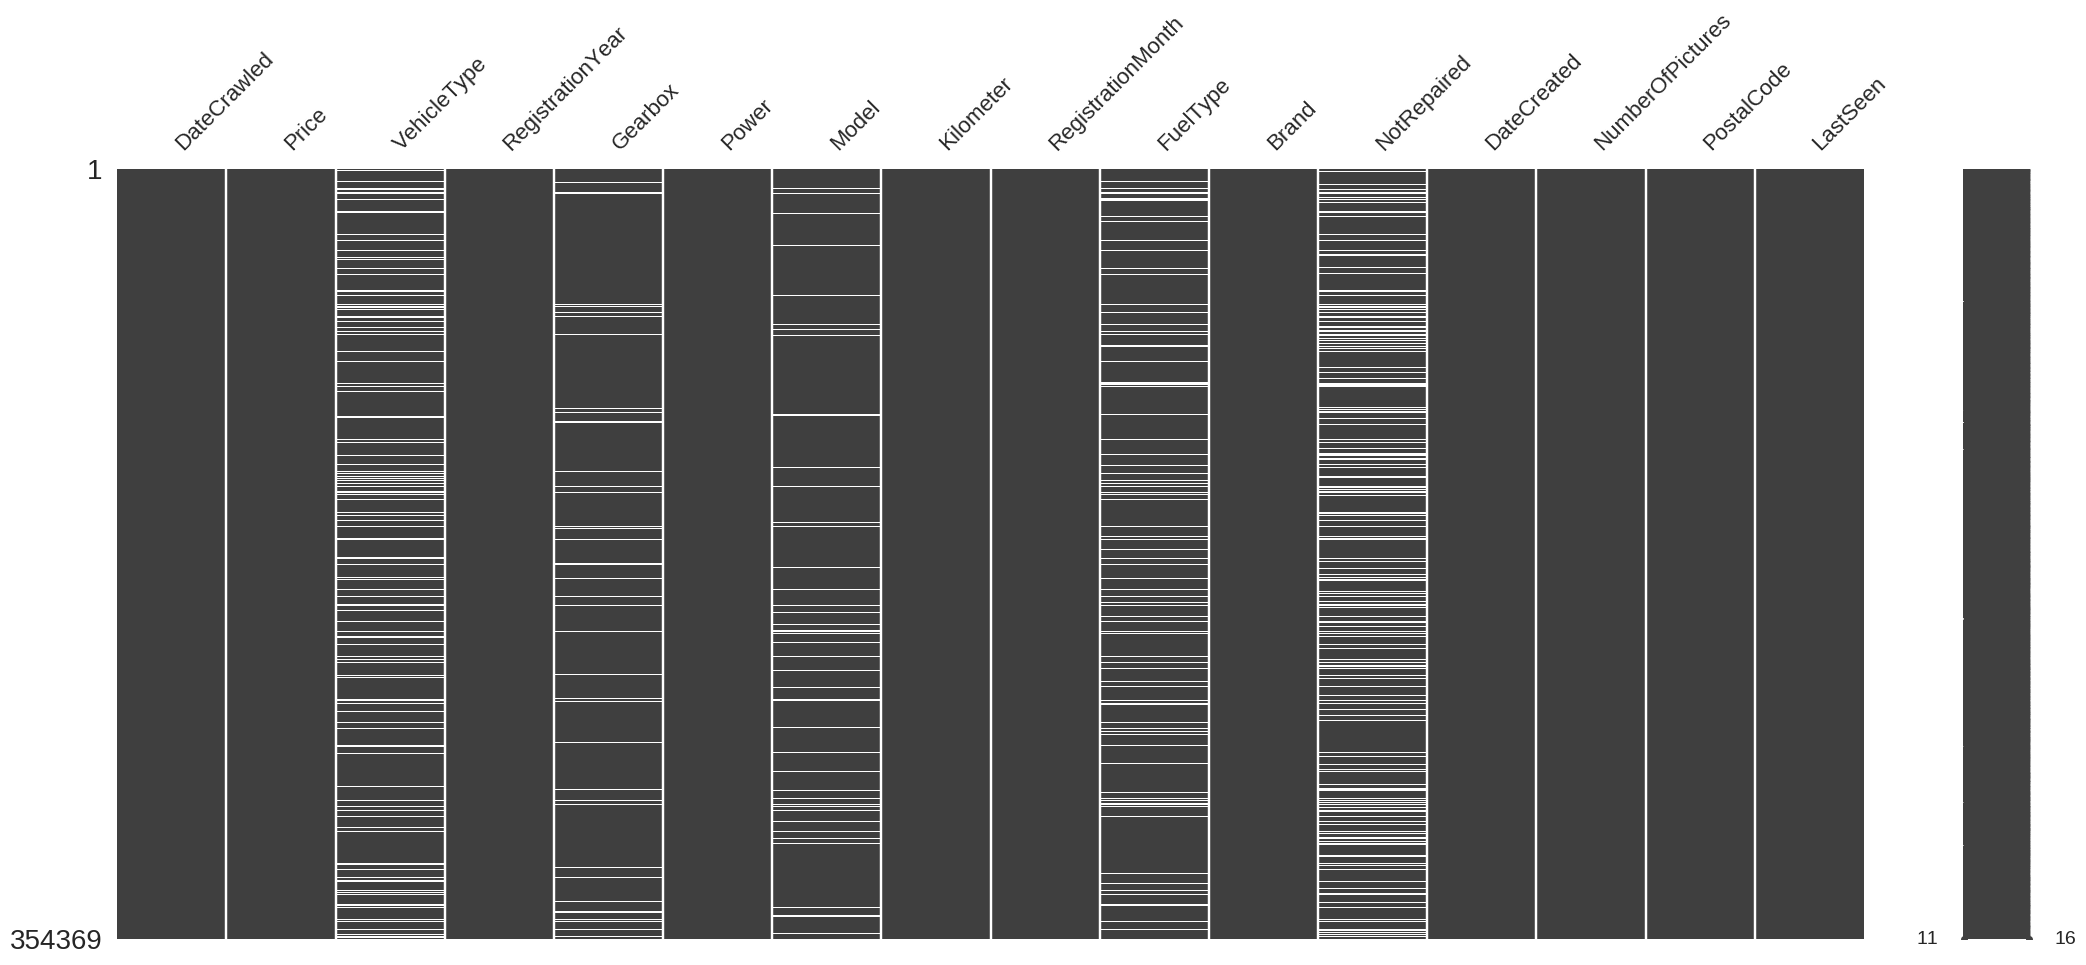

In [6]:
# Визуализируем количество пропусков в данных
msno.matrix(df)

In [7]:
# Посмотрим сколько в наших данных пропущенных значений и их доли от общего количества значений 
isnull = df.isnull().sum()
notnull = df.notnull().sum()
percent = (round(df.isnull().sum()/df.isnull().count()*100, 1)).sort_values(ascending=False)
missing_data = pd.concat([isnull, notnull, percent], axis=1, keys=['Есть пропуски', "Нет пропусков", 'Процент пропусков'])
missing_data.sort_values(by='Процент пропусков', ascending=False)

,Есть пропуски,Нет пропусков,Процент пропусков
NotRepaired,71154,283215,20.1
VehicleType,37490,316879,10.6
FuelType,32895,321474,9.3
Gearbox,19833,334536,5.6
Model,19705,334664,5.6
Brand,0,354369,0.0
DateCrawled,0,354369,0.0
DateCreated,0,354369,0.0
Kilometer,0,354369,0.0
LastSeen,0,354369,0.0


#### Вывод

Ознакомившись с набором данных мы видим, что в нём 354369 строк и 16 признаков.

Посмотрим какая информация содержится в каждой колонке:
    
    Price — цена автомобиля в евро (целевой признак)
    
    DateCrawled — дата скачивания анкеты из базы
    VehicleType — тип автомобильного кузова
    RegistrationYear — год регистрации автомобиля
    Gearbox — тип коробки передач
    Power — мощность автомобиля(л. с.)
    Model — модель автомобиля
    Kilometer — пробег автомобиля(км)
    RegistrationMonth — месяц регистрации автомобиля
    FuelType — тип топлива
    Brand — марка автомобиля
    NotRepaired — была машина в ремонте или нет
    DateCreated — дата создания анкеты
    NumberOfPictures — количество фотографий автомобиля
    PostalCode — почтовый индекс владельца анкеты (пользователя)
    LastSeen — дата последней активности пользователя
    
Из них:
    
    int64 (7 признаков) 
    object (9 признаков)

В данных выявлены четыре строки с дубликатами.

В колонке `NumberOfPictures` все значения равны нулю.

При подготовке данных вероятно допущена ошибка при формировании признака `DateCreated` - совпадает с датой скачивания анкеты из базы, но время пустое, данный признак не информативен.
    
Анализ пропусков в признаках:

`VehicleType` - 37490 (10.6% пропущенных значений)  
`Gearbox` - 19833 (5.6% пропущенных значений)  
`Model` - 19705 (5.6% пропущенных значений)  
`FuelType` - 32895 (9.3% пропущенных значений)  
`NotRepaired` - 71154 (20.1% пропущенных значений)  
    
Анализ нулевых значений в признаках:

`Price` - 10772 (3.0% нулевый значений)  
`Power` - 40225 (11.4% нулевый значений)  
`RegistrationMonth` - 37352 (10.5% нулевый значений)  
    
Требуется преобразовать тип данных для признаков:

object -> DataTime:

`DateCrawled`, `LastSeen` (в признаках хранится дата)

Требуется:
    
- Удалить признак `NumberOfPictures` - признак не содержит значений.  
- Удалить признак `DateCreated`.
- Удалить выявленные дубликаты.
- Перед заполнением пропусков на каждую колонку с пропусками добавить колонку "флаг" типа bool - есть/нет пропуск.
- Пропуски в признаках `VehicleType`, `Gearbox`, `Model`, `FuelType`, `NotRepaired` заменить на 'other'.
- В признаке `Price` удалить нули и значения ниже 100.
- В признаке `Power` удалить значения выходящие вне диапозона 20-500.        
- В признаке `RegistrationYear` удалить значения выходящие за диапозон 1900-2020.
- В случае использования модели линейной регрессии сделать стандартизацию: преобразование с помощью LabelEncoding.

<a href='#Назад к оглавлению'> Назад к оглавлению</a>

<a id='Часть 2. Предобработка данных'></a>

### Часть 2. Предобработка данных

In [6]:
# Удалим строки с дубликатами и сбросим индексы
df = df.drop_duplicates(keep='first').reset_index(drop=True)

In [7]:
# Проверим что дубликаты удалены
df.duplicated().sum()

0

In [8]:
# Удалим колонки NumberOfPictures и DateCreated
df = df.drop(['NumberOfPictures', 'DateCreated'], axis=1)

In [9]:
# Напишем функцию для создания индикатора пропусков для передаваемой переменной 
def missing_flag(feature):
    """
    На вход принимает признак у которого есть пропуски, значение типа str
    Создает экземпляр класса MissingIndicator
    Обучает модель импутации
    Применяет обученную модель импутации к принятой переменной
    Результат сохраняет в новой колонке под названием имя_переменной+_flag
    """    
    miss_ind = MissingIndicator()
    miss_ind.fit(df[[feature]])
    df[feature + '_flag'] = miss_ind.transform(df[[feature]])

In [10]:
# Делаем вызов функции missing_flag
for column_name in ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired']:
    missing_flag(column_name)

In [11]:
# Преобразование типа данных для временны признаков
df['DateCrawled'] = pd.to_datetime(df['DateCrawled']).astype(np.int64) // 10 ** 9
df['LastSeen'] = pd.to_datetime(df['LastSeen']).astype(np.int64) // 10 ** 9

In [12]:
# Пропуски в признаках `VehicleType`, `Gearbox`, `Model`, `FuelType`, `NotRepaired` заменим на 'other'
for column in ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired']:
    df[column] = df[column].fillna('other')

In [13]:
df.describe()

,DateCrawled,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,PostalCode,LastSeen
count,3.543650e+05,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,3.543650e+05
mean,1.458565e+09,4416.679830,2004.234481,110.093816,128211.363989,5.714650,50508.503800,1.459295e+09
std,7.864397e+05,4514.176349,90.228466,189.851330,37905.083858,3.726432,25783.100078,7.933289e+05
min,1.457187e+09,0.000000,1000.000000,0.000000,5000.000000,0.000000,1067.000000,1.457187e+09
25%,1.457870e+09,1050.000000,1999.000000,69.000000,125000.000000,3.000000,30165.000000,1.458701e+09
50%,1.458583e+09,2700.000000,2003.000000,105.000000,150000.000000,6.000000,49413.000000,1.459697e+09
75%,1.459262e+09,6400.000000,2008.000000,143.000000,150000.000000,9.000000,71083.000000,1.459938e+09
max,1.460040e+09,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,99998.000000,1.460041e+09


In [14]:
# Удаляем значения из признаков Power, Price, RegistrationYear выходящие за адекватный диапазон
df = df.query('30 <= Power <= 500')
df = df.query('Price >= 100')
df = df.query('1900 <= RegistrationYear <= 2020')

In [15]:
df.describe()

,DateCrawled,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,PostalCode,LastSeen
count,3.047000e+05,304700.000000,304700.000000,304700.000000,304700.000000,304700.000000,304700.000000,3.047000e+05
mean,1.458566e+09,4831.243692,2003.355028,120.453810,128609.796521,5.972678,51178.253364,1.459312e+09
std,7.875155e+05,4585.886680,6.844792,53.210984,36490.472131,3.596023,25748.181991,7.872622e+05
min,1.457187e+09,100.000000,1910.000000,30.000000,5000.000000,0.000000,1067.000000,1.457187e+09
25%,1.457870e+09,1350.000000,1999.000000,75.000000,125000.000000,3.000000,30926.000000,1.458738e+09
50%,1.458583e+09,3150.000000,2003.000000,110.000000,150000.000000,6.000000,50171.000000,1.459727e+09
75%,1.459263e+09,6980.000000,2008.000000,150.000000,150000.000000,9.000000,71711.000000,1.459940e+09
max,1.460040e+09,20000.000000,2019.000000,500.000000,150000.000000,12.000000,99998.000000,1.460041e+09


#### Вывод

- Удалены признаки `NumberOfPictures` и `DateCreated`.
- Удалены выявленные дубликаты.
- Для признаков `VehicleType`, `Gearbox`, `Model`, `FuelType`, `NotRepaired` добавлена колонка-флаг наличия пропуска. 
- Пропуски в признаках `VehicleType`, `Gearbox`, `Model`, `FuelType`, `NotRepaired` заменены на 'other'.
- Удалены значения признаков `Power`, `Price`, `RegistrationYear` выходящие за адекватный диапазоны.

<a href='#Назад к оглавлению'> Назад к оглавлению</a>

<a id='Часть 3. Разбиение данных на выборки'></a>

### Часть 3. Разбиение данных на выборки и построение моделей

#### 3.1 Разбиение данных на выборки

In [16]:
# В переменную features поместим датасет удалив колонку Price
# Отделим от датасета колонку Price с целевой переменной и поместим её в переменную target
features = df.drop(['Price'], axis=1)
target = df['Price']

In [18]:
# Поделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=42)

In [20]:
# Создаем список категориальных переменных
cat_columns = X_train.dtypes[X_train.dtypes == 'object'].index.tolist()
# Создаем список количественных переменных
num_columns = X_train.dtypes[X_train.dtypes != 'object'].index.tolist()

In [21]:
# Удаляем из списка количественных переменных
# переменные содержащие даты
date_columns = ['DateCrawled', 'LastSeen']
num_columns = list(set(num_columns).difference(set(
    date_columns)))
# Смотрим итоговый список категориальных переменных
num_columns

['Power',
 'VehicleType_flag',
 'RegistrationMonth',
 'RegistrationYear',
 'NotRepaired_flag',
 'FuelType_flag',
 'PostalCode',
 'Kilometer',
 'Gearbox_flag',
 'Model_flag']

In [22]:
# Функция расчета метрики root mean squared error
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)**0.5

<a href='#Назад к оглавлению'> Назад к оглавлению</a>

<a id='3.2 Константная модель'></a>

#### 3.2 Константная модель

Запуск константной модели для возможности проверки последующих моделей на адекватность. Предсказание - медиана обучающей выборки

In [23]:
# Напишем класс константной модели
class ConstantModel:
    
    def fit(self, y_train):
        self.median = y_train.median()

    def predict(self, X_test):
        return np.ones(len(X_test)) * self.median

In [24]:
# Инициализируем модель
model_const = ConstantModel()

In [25]:
# Обучаем модель
start = timeit.default_timer()
model_const.fit(y_train)
stop = timeit.default_timer()

fit_time_const = round(stop - start, 4)
print('Время обучения константной модели: ', fit_time_const)

Время обучения константной модели:  0.0063


In [26]:
# Получаем предсказания на тестовой выборке
start = timeit.default_timer()
predict_const = model_const.predict(X_test)
stop = timeit.default_timer()

pred_time_const = round(stop - start, 4)
print('Время предсказания константной модели: ', pred_time_const)

Время предсказания константной модели:  0.0006


In [27]:
# Проверяем метрику получившейся модели
rmse_const = round(rmse(y_test, predict_const), 2)
print('RMSE константной модели на тестовой выборке:', rmse_const)

RMSE константной модели на тестовой выборке: 4877.98


In [28]:
# Соберем в список всю информацию по модели
# Зафиксируем время, потребовавшееся для подготовки признаков, перед использованием модели - 0
prep_time = 0.0
lst_const = ['Constant model', prep_time, fit_time_const, pred_time_const, rmse_const]
lst_const

['Constant model', 0.0, 0.0063, 0.0006, 4877.98]

<a href='#Назад к оглавлению'> Назад к оглавлению</a>

<a id='3.3 Random Forest Regressor'></a>

#### 3.3 Random Forest Regressor

Проверим простую модель Random Forest Regressor. Для нее понадобится обработать категориальные признаки - применим метод LabelEncoder. 

In [29]:
# Применяем LabelEncoder
start = timeit.default_timer()
X_train_le = X_train.copy()
X_test_le = X_test.copy()

for category in cat_columns:
    le = LabelEncoder()
    X_train_le[category] = le.fit_transform(X_train_le[category])
    X_test_le[category] = le.transform(X_test_le[category])

stop = timeit.default_timer()

prep_time_le = round(stop - start, 4)
print('Время подготовки признаков для модели: ', prep_time_le)

Время подготовки признаков для модели:  0.5256


In [30]:
# Инициализируем модель
model_rfr = RandomForestRegressor(random_state=12345)

In [31]:
# Обучаем модель
start = timeit.default_timer()
model_rfr.fit(X_train_le, y_train)
stop = timeit.default_timer()

fit_time_rfr = round(stop - start, 4)
print('Время обучения Random Forest Regressor: ', fit_time_rfr)

Время обучения Random Forest Regressor:  22.5543


In [32]:
# Получаем предсказания на тестовой выборке
start = timeit.default_timer()
predict_rfr = model_rfr.predict(X_test_le)
stop = timeit.default_timer()

pred_time_rfr = round(stop - start, 4)
print('Время предсказания Random Forest Regressor: ', pred_time_rfr)

Время предсказания Random Forest Regressor:  0.5988


In [33]:
# Проверяем метрику получившейся модели
rmse_rfr = round(rmse(y_test, predict_rfr), 2)
print('RMSE Random Forest Regressor на тестовой выборке:', rmse_rfr)

RMSE Random Forest Regressor на тестовой выборке: 1639.7


In [34]:
# Соберем в список всю информацию по модели
lst_rfr = ['Random Forest Regressor', prep_time_le, fit_time_rfr, pred_time_rfr, rmse_rfr]
lst_rfr

['Random Forest Regressor', 0.5256, 22.5543, 0.5988, 1639.7]

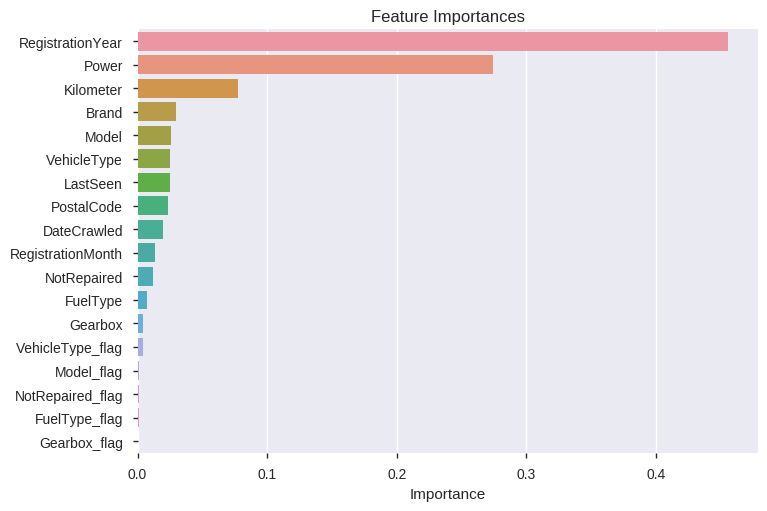

In [35]:
# Посмотрим на top важных признаков
importances = pd.DataFrame(model_rfr.feature_importances_, index = X_train.columns, columns=['Importance'])
sns.barplot(data=importances, x='Importance', y=importances.index, 
            order = importances.sort_values(by='Importance', ascending = False).index)
plt.title('Feature Importances');  

In [36]:
# Подберем параметры для модели Random Forest Regressor с помощью Randomized SearchCV
model_rfr_rs = RandomForestRegressor(random_state=12345)

kf = KFold(n_splits=3, random_state=12345)

param_grid = {'max_depth': [10, 20, 50],
              'min_samples_split' : [7, 10, 12]}

rmse_rs = make_scorer(rmse)

rs = RandomizedSearchCV(model_rfr_rs, 
                   param_grid, 
                   scoring=rmse_rs, 
                   cv=kf,
                   n_jobs=-1,)

start = timeit.default_timer()
rs.fit(X_train_le, y_train)
stop = timeit.default_timer()
fit_time_rs = round(stop - start, 4)
print('Время подбора оптимальных параметров для Random Forest Regressor с подобранными поиском по сетке параметрами: ', fit_time_rs)


print('Наилучшие значения гиперпараметров: {}'.format(rs.best_params_))

start = timeit.default_timer()
predict_rs = rs.best_estimator_.predict(X_test_le)
stop = timeit.default_timer()
pred_time_rs = round(stop - start, 4)
print('Время предсказания Random Forest Regressor с подобранными поиском по сетке параметрами: ', pred_time_rfr)


# Проверяем метрику получившейся модели
rmse_rs = round(rmse(y_test, predict_rs), 2)
print('RMSE Random Forest Regressor с подобранными поиском по сетке параметрами на тестовой выборке:', rmse_rs)

Время подбора оптимальных параметров для Random Forest Regressor с подобранными поиском по сетке параметрами:  286.1231
Наилучшие значения гиперпараметров: {'min_samples_split': 10, 'max_depth': 10}
Время предсказания Random Forest Regressor с подобранными поиском по сетке параметрами:  0.5988
RMSE Random Forest Regressor с подобранными поиском по сетке параметрами на тестовой выборке: 1875.16


In [37]:
# Соберем в список всю информацию по модели
lst_rfr_rs = ['Random Forest Regressor_RS', prep_time_le, fit_time_rs, pred_time_rs, rmse_rs]
lst_rfr_rs

['Random Forest Regressor_RS', 0.5256, 286.1231, 0.1723, 1875.16]

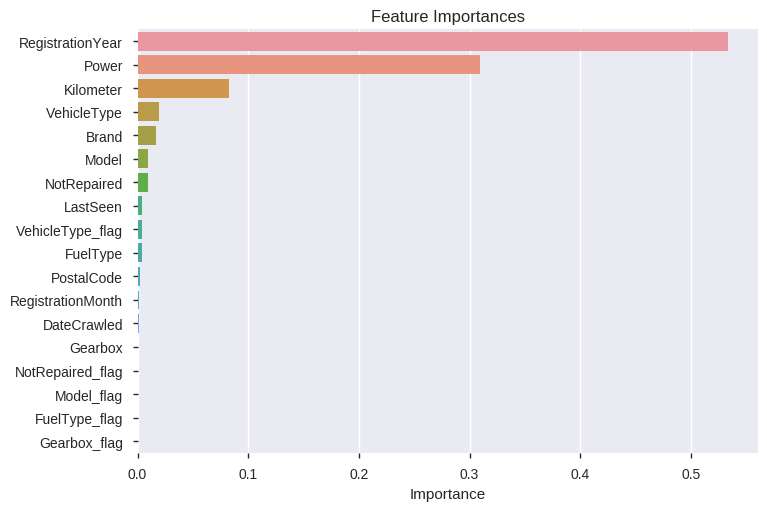

In [38]:
# Посмотрим на top важных признаков
model_rfr_rs = rs.best_estimator_.fit(X_train_le, y_train)
importances = pd.DataFrame(model_rfr_rs.feature_importances_, index = X_train.columns, columns=['Importance'])
sns.barplot(data=importances, x='Importance', y=importances.index, 
            order = importances.sort_values(by='Importance', ascending = False).index)
plt.title('Feature Importances');  

<a href='#Назад к оглавлению'> Назад к оглавлению</a>

<a id='3.4 LGBM'></a>

#### 3.4 LGBM

Запустим модель LightGBM. Для нее тоже необходимо обрабатывать категориальные признаки с помощью метода LabelEncoder (реализовано ранее). 

In [39]:
# Задаём параметры для модели
train_data = lgbm.Dataset(X_train_le, label=y_train, categorical_feature=cat_columns)
test_data = lgbm.Dataset(X_test_le, label=y_test)

params = {
    'objective': 'regression', 
    'metric': 'l2', 
    'boosting': 'gbdt', 
    'learning_rate': 0.1,
    'verbose': -1,
    'num_leaves': 32,
    'max_depth': 25,
    'force_row_wise': True, 
    'silent': True
}

In [40]:
# Обучаем модель
start = timeit.default_timer()
model_lgbm = lgbm.train(params,
                       train_data,
                       categorical_feature=cat_columns,
                       num_boost_round=200)
stop = timeit.default_timer()
fit_time_lgbm = round(stop - start, 4)
print('Время обучения LightGBM: ', fit_time_lgbm)

Время обучения LightGBM:  22.3689


In [41]:
# Получаем предсказания на тестовой выборке
start = timeit.default_timer()
predict_lgbm = model_lgbm.predict(X_test_le)
stop = timeit.default_timer()
pred_time_lgbm = round(stop - start, 4)
print('Время предсказания LightGBM: ', pred_time_lgbm)

Время предсказания LightGBM:  2.5105


In [42]:
# Проверяем метрику получившейся модели
rmse_lgbm = round(rmse(y_test, predict_lgbm), 2)
print('RMSE LightGBM на тестовой выборке:', rmse_lgbm)

RMSE LightGBM на тестовой выборке: 1533.5


In [43]:
# Соберем в список всю информацию по модели
lst_lgbm = ['LightGBM', prep_time_le, fit_time_lgbm, pred_time_lgbm, rmse_lgbm]
lst_lgbm

['LightGBM', 0.5256, 22.3689, 2.5105, 1533.5]

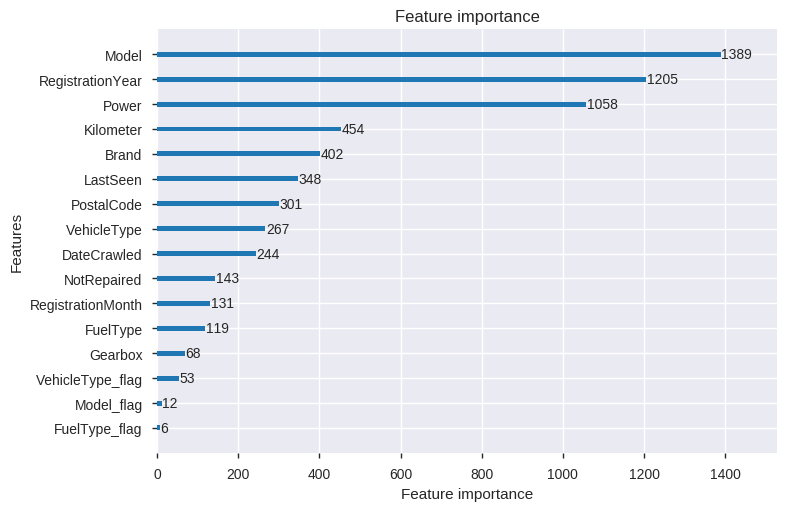

In [44]:
# Посмотрим на top важных признаков 
lgbm.plot_importance(model_lgbm);

<a href='#Назад к оглавлению'> Назад к оглавлению</a>

<a id='3.5 CatBoost'></a>

#### 3.5 CatBoost

Запустим модель CatBoost.

In [45]:
# Обучаем модель
model_cb = CatBoostRegressor(iterations=200, eval_metric='RMSE', learning_rate=0.1, random_seed=42, logging_level='Silent')

start = timeit.default_timer()
model_cb.fit(X_train, y_train, cat_features=cat_columns)# Поставив параметр plot=True можно увидеть визуализацию, но на jupiterhub kernel умирает
stop = timeit.default_timer()
fit_time_cb = round(stop - start, 4)
print('Время обучения LightGBM: ', fit_time_cb)

Время обучения LightGBM:  178.4658


In [46]:
# Получаем предсказания на тестовой выборке
start = timeit.default_timer()
predict_cb = model_cb.predict(X_test)
stop = timeit.default_timer()
pred_time_cb = round(stop - start, 4)
print('Время предсказания LightGBM: ', pred_time_cb)

Время предсказания LightGBM:  0.5253


In [47]:
# Проверяем метрику получившейся модели
rmse_cb = round(rmse(y_test, predict_cb), 2)
print('RMSE LightGBM на тестовой выборке:', rmse_cb)

RMSE LightGBM на тестовой выборке: 1636.24


In [48]:
# Соберем в список всю информацию по модели
prep_time_cb = 0.0
lst_cb = ['CatBoost', prep_time_cb, fit_time_cb, pred_time_cb, rmse_cb]
lst_cb

['CatBoost', 0.0, 178.4658, 0.5253, 1636.24]

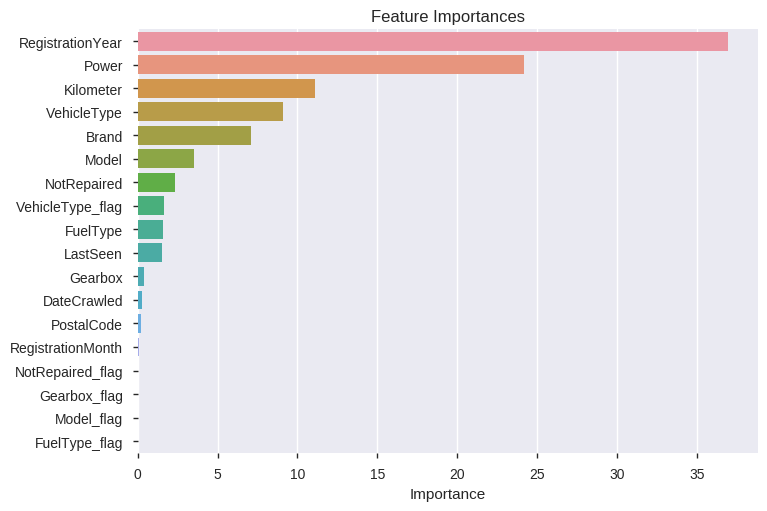

In [49]:
# Посмотрим на top важных признаков
importances = pd.DataFrame(model_cb.feature_importances_, index = X_train.columns, columns=['Importance'])
sns.barplot(data=importances, x='Importance', y=importances.index, 
            order = importances.sort_values(by='Importance', ascending = False).index)
plt.title('Feature Importances');  

<a href='#Назад к оглавлению'> Назад к оглавлению</a>

<a id='4. Общий вывод'></a>

### 4. Общий вывод

In [51]:
# Соберем итоговую таблицу по моделям
res_lst = [lst_const, lst_rfr, lst_lgbm, lst_cb]
result_df = pd.DataFrame(res_lst,
                   columns=['Модель', 'Время на подготовку признаков, сек.', 'Скорость обучения, cек.', 'Скорость предсказания, cек.', 'Качество предсказания  (RMSE)'])
result_df.sort_values(by='Качество предсказания  (RMSE)')

,Модель,"Время на подготовку признаков, сек.","Скорость обучения, cек.","Скорость предсказания, cек.",Качество предсказания (RMSE)
2,LightGBM,0.5256,22.3689,2.5105,1533.50
3,CatBoost,0.0000,178.4658,0.5253,1636.24
1,Random Forest Regressor,0.5256,22.5543,0.5988,1639.70
0,Constant model,0.0000,0.0063,0.0006,4877.98


Произведена предобработка данных - данные содержали пропущенные значения и значения не соответствующие адекватным диапазонам.   
Произведена подготовка данных для моделирования и предподготовка в соответствии с требованиями моделей.   
Продемонстрировано обучение моделей Random Forest Regressor, LightGBM, CatBoost.  
В сравнении с константной моделью, они все показали более высокие результаты - модели адекватны. 

Сравнение по скорости показало, что быстрее всего отрабатывает Константная модель.  
Сравнение по качеству метрики RMSE показало, что лучшее качество у модели LGBM.  
Для моделей LGBM и Random Forest Regressor требуется дополнительная предподготовка признаков, которая тоже может занимать время. 

<a href='#Назад к оглавлению'> Назад к оглавлению</a>